In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import make_grid
import time
import sys
import os
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
## If GPU is available, then the code will be pushed to it otherwise it will move to CPU 
use_cuda=torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
#### Hyperparameters

batch_size=50
epochs=5
input_size=10 
num_layers=1
bd_flag=False
hidden_state_size=2 ##TODO: tune it get better results

In [6]:
##Loading the data
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
train_data = datasets.MNIST(root='../data', train=True,download=True, transform=transform)
test_dataset = datasets.MNIST(root='../data', train=False,download=True, transform=transform)

##Splitting dataset
train_size=50000
validation_size=10000

train_dataset, validation_dataset = torch.utils.data.random_split(train_data, [train_size, validation_size])

##Building the Dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
validation_loader=torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

## $Implementing$ $various$ $model-structure$ $from$ $Question $ $1$

In [7]:
class RNN(nn.Module):
    
    def __init__(self,input_size = input_size,hidden = hidden_state_size, number_of_layers= num_layers, bd_flag = bd_flag): 
        super(RNN, self).__init__() 
        
        self.rnn = nn.RNN(input_size = input_size, 
                          hidden_size = hidden, 
                          num_layers = number_of_layers,
                          bidirectional = bd_flag, 
                          batch_first = True)
        
        
        self.hidden_layer = nn.Linear(hidden + hidden*bd_flag ,10) #as size of the output is 10
        
        self.logsoftmax = nn.LogSoftmax(dim = 1)
    
    def forward(self,x): 
        
        out,hidden_ = self.rnn(x)
        
        #we want the output at the last time step alone so out[:,-1,:] gives o/p of shape (batch,hidden)
        
        out = self.hidden_layer(out[:,-1,:]) 
        
        prediction   = self.logsoftmax(out)
        
        return prediction

In [8]:
class LSTM(nn.Module):
    
    def __init__(self, input_size=input_size, hidden = hidden_state_size, number_of_layers= num_layers, bd_flag = bd_flag):
        super(LSTM,self).__init__()
        
        self.hidden=hidden
        
        self.bd_flag = bd_flag
        
        self.lstm=nn.LSTM(input_size = input_size, 
                          hidden_size = hidden, 
                          num_layers = number_of_layers,
                          bidirectional = bd_flag, 
                          batch_first = True)
        
        self.hidden_layer = nn.Linear(hidden + hidden*bd_flag ,10) #as size of the output is 10
        
        self.logsoftmax = nn.LogSoftmax(dim = 1)
        
    def forward(self,x):
        
        ## Setting initial cell and hidden states
        h0 = torch.zeros(1+self.bd_flag, x.size(0), self.hidden).to(device) 
        c0 = torch.zeros(1+self.bd_flag, x.size(0), self.hidden).to(device)
        
        out,hidden_ = self.lstm(x,(h0,c0))
        
        #we want the output at the last time step alone so out[:,-1,:] gives o/p of shape (batch,hidden)
        
        out = self.hidden_layer(out[:,-1,:]) 
        
        prediction   = self.logsoftmax(out)
        
        return prediction
        
        

In [9]:
class GRU(nn.Module):
    
    def __init__(self, input_size=input_size, hidden = hidden_state_size, number_of_layers= num_layers, bd_flag = False):
        super(GRU,self).__init__()
        
        self.hidden = hidden
        
        self.input_size = input_size
        
        self.num_layers = number_of_layers
        
        self.bd_flag = bd_flag
        
        self.gru=nn.GRU(input_size, hidden, num_layers, batch_first=True)
        
        self.hidden_layer = nn.Linear(hidden + hidden*bd_flag ,10) #as size of the output is 10
        
        self.logsoftmax = nn.LogSoftmax(dim = 1)
        
    def forward(self,x):
        
        ## Setting initial cell and hidden states
        h0 = torch.zeros(1+self.bd_flag, x.size(0), self.hidden).to(device) 
        
        out,hidden_ = self.gru(x,h0)
        
        #we want the output at the last time step alone so out[:,-1,:] gives o/p of shape (batch,hidden)
        
        out = self.hidden_layer(out[:,-1,:]) 
        
        prediction   = self.logsoftmax(out)
        
        return prediction
        
        

In [10]:
def train(model,device,train_loader,optimizer,epoch,train_loss,train_accuracy):
    model.train()
    acc=0
    train_l=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1,28,28)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        #train_loss.append(loss.item())
        train_l+=loss.item()
        pred= output.argmax(dim=1, keepdim=True)
        acc+= pred.eq(target.view_as(pred)).sum().item()
        
    train_loss.append(train_l/len(train_loader.dataset))
    train_accuracy.append(100*acc/len(train_loader.dataset))
        

In [11]:
def test(model,device,test_loader,test_loss,test_accuracy):
    model.eval()
    loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(-1,28,28)
            output = model(data)
            loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            acc += pred.eq(target.view_as(pred)).sum().item()

    loss /= len(test_loader.dataset)
    test_loss.append(loss)
    test_accuracy.append(100. * acc / len(test_loader.dataset))

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, acc, len(test_loader.dataset),
        100. * acc / len(test_loader.dataset)))

### Implementing the Models

In [10]:
model=[RNN(),LSTM(),GRU()]
network=model[1]
model=network.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
train_loss=[]
train_accuracy=[]
validation_loss=[]
validation_accuracy=[]
test_loss=[]
test_accuracy=[]
start=time.time()
for epoch in range(1,epochs+1):
    train(model,device,train_loader,optimizer,epoch,train_loss,train_accuracy)
    
    test(model, device, validation_loader,validation_loss,validation_accuracy)
end=time.time()


Validation set: Average loss: 0.4134, Accuracy: 8813/10000 (88%)


Validation set: Average loss: 0.2153, Accuracy: 9399/10000 (94%)


Validation set: Average loss: 0.1690, Accuracy: 9504/10000 (95%)


Validation set: Average loss: 0.1321, Accuracy: 9622/10000 (96%)


Validation set: Average loss: 0.1160, Accuracy: 9653/10000 (97%)



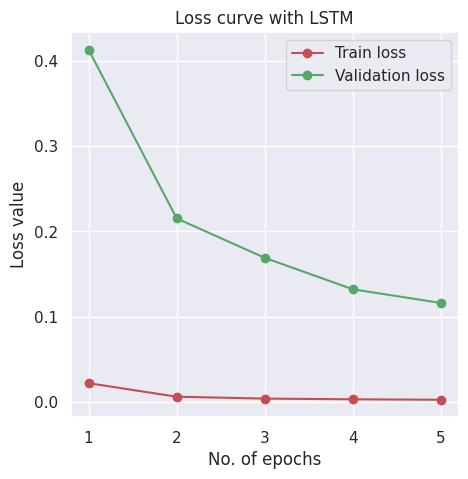

In [12]:
sns.set_theme()
plt.figure(figsize=(5, 5))
xval=np.arange(1,epochs+1,1)
plt.plot(xval,train_loss,color='r',marker='o')
plt.plot(xval,validation_loss,color='g',marker='o')
plt.xlabel("No. of epochs")
plt.ylabel("Loss value")
plt.legend(["Train loss","Validation loss"])
plt.title("Loss curve with LSTM")
plt.grid(True)

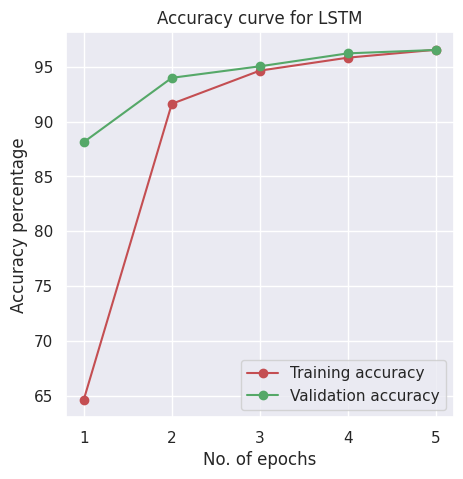

In [13]:
plt.figure(figsize=(5, 5))
x=np.arange(1,epochs+1,1)
plt.plot(x,train_accuracy,color='r',marker='o')
plt.plot(x,validation_accuracy,color='g',marker='o')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy percentage")
plt.legend(["Training accuracy","Validation accuracy"])
plt.title("Accuracy curve for LSTM")
plt.grid(True)

In [14]:
test(model, device, test_loader,test_loss,test_accuracy)


Validation set: Average loss: 0.1173, Accuracy: 9651/10000 (97%)



In [15]:
avg_acc=sum(test_accuracy)/len(test_accuracy)
print("The average accuracy of the test set is : {:.6f} ".format(avg_acc))

The average accuracy of the test set is : 96.510000 


In [16]:
### Cearly LSTM is the best model so I used that for random predictions

def random_predictions(model,test_data):
    img_idx=np.random.randint(0,10000,size=5)
    fig = plt.figure(figsize=(5, 5))
    for idx in img_idx:
        true_img,_=test_data[idx]
        with torch.no_grad():
            
            true_img = true_img.reshape(1,1,28,28).cuda().float()
            output=model.forward(true_img.view(-1,28,28)).detach().cpu().numpy()
            
            prediction=np.argmax(output)
            
            plt.imshow(true_img.detach().cpu().numpy().reshape(28,28),cmap='viridis')
            plt.axis('off')
            plt.title(f"Predicted as {prediction}")

        

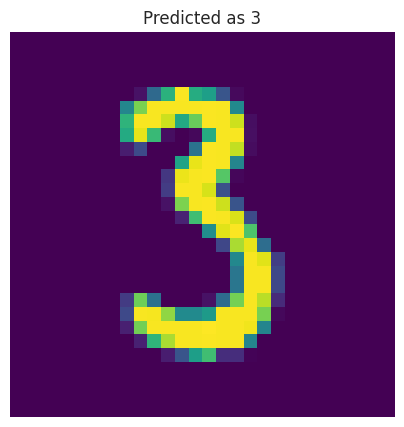

In [17]:
random_predictions(model,test_dataset)

### $Q2 : $ $Remembering$ $the$ $number$ $pertaining$ $to$ $a$ $particular$ $index$ $in$ $the$ $sequence$

In [12]:
#### Hyperparameter
epochs=20
position=2 
max_iter=3000
test_iter=500
input_size=10 
num_layers=1
bd_flag=False
hidden_state_size=2 ##TODO: tune it get better results

rnn_model=RNN().to(device)
lstm_model=LSTM().to(device)
gru_model=GRU().to(device)

optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=0.0001)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.0001)
optimizer_gru = optim.Adam(gru_model.parameters(), lr=0.0001)


In [13]:
def convert_to_onehot(labels,num_classes):
    output = np.eye(num_classes)[np.array(labels).reshape(-1)]
    return output.reshape(list(np.shape(labels))+[num_classes])

In [14]:
position=2
def modelled_sequence(L,k=position):
    generated_seq = np.random.randint(0, 9,size=L)
    
    xinput = np.zeros((1,L,10))
    for i in range(L):
        xinput[0][i]=convert_to_onehot(generated_seq[i],10)
    y=convert_to_onehot(generated_seq[k],10)
    y= y[np.newaxis, :] 
    
    
    generated_seq = torch.tensor(generated_seq,dtype=torch.float) 
    xinput = torch.tensor(xinput,dtype=torch.float)
    y = torch.tensor(y,dtype=torch.float)
    
    return generated_seq,xinput,y
    

In [15]:
def train_sequence(model,device,optimizer,train_error,train_acc):
        model.train()
        acc=0
        train_l=0

        for i in range(max_iter):

            L = np.random.randint(3,10)

            seq_gen,x,y=modelled_sequence(L)

            x=x.to(device)
            y=y.to(device)


            prediction=model(x)

            loss = F.nll_loss(prediction, y.argmax(axis = 1))

            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()


            train_l+=loss.item()

            y=y.detach().cpu().numpy()
            pred=prediction.detach().cpu().numpy()

            acc+= (np.asarray(pred.argmax(axis = 1)-y.argmax(axis = 1))==0).sum()

        train_error.append(train_l/max_iter)
        train_acc.append(100*acc/max_iter)
        #return train_l/max_iter,100*acc/max_iter

       

In [16]:
def test_sequence(model,device,optimizer,test_loss,test_acc):
    model.eval()
    acc=0
    test_l=0
    with torch.no_grad():
        
        for i in range(test_iter):
            L = np.random.randint(3,10)

            seq_gen,x,y=modelled_sequence(L)

            x=x.to(device)
            y=y.to(device)


            prediction=model(x)

            loss = F.nll_loss(prediction, y.argmax(axis = 1))
            
            test_l+=loss.item()

            y=y.detach().cpu().numpy()
            pred=prediction.detach().cpu().numpy()

            acc+= (np.asarray(pred.argmax(axis = 1)-y.argmax(axis = 1))==0).sum()
            
    test_loss.append(test_l/test_iter)
    test_acc.append(100*acc/test_iter)
            
    
    

In [17]:
train_err_rnn=[]
train_acc_rnn=[]
train_err_lstm=[]
train_acc_lstm=[]
train_err_gru=[]
train_acc_gru=[]

test_err_rnn=[]
test_acc_rnn=[]
test_err_lstm=[]
test_acc_lstm=[]
test_err_gru=[]
test_acc_gru=[]

for i in range(epochs):
    train_sequence(rnn_model,device,optimizer_rnn,train_err_rnn,train_acc_rnn)
    train_sequence(lstm_model,device,optimizer_lstm,train_err_lstm,train_acc_lstm)
    train_sequence(gru_model,device,optimizer_gru,train_err_gru,train_acc_gru)
    
    test_sequence(rnn_model,device,optimizer_rnn,test_err_rnn,test_acc_rnn)
    test_sequence(lstm_model,device,optimizer_lstm,test_err_lstm,test_acc_lstm)
    test_sequence(gru_model,device,optimizer_gru,test_err_gru,test_acc_gru)

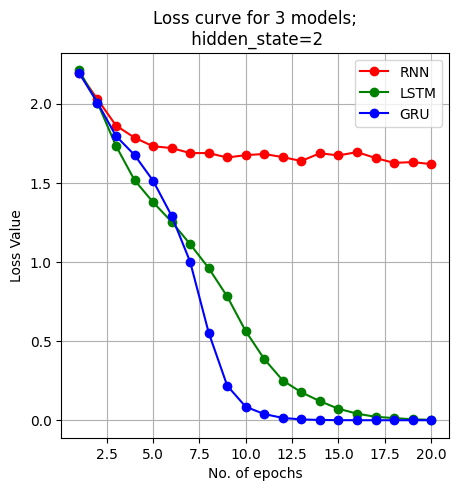

In [15]:
plt.figure(figsize=(5, 5))
x=np.arange(1,epochs+1,1)
plt.plot(x,train_err_rnn,color='r',marker='o')
plt.plot(x,train_err_lstm,color='g',marker='o')
plt.plot(x,train_err_gru,color='b',marker='o')

plt.xlabel("No. of epochs")
plt.ylabel("Loss Value")
plt.legend(["RNN","LSTM","GRU"])
plt.title("Loss curve for 3 models;\n hidden_state=2")
plt.grid(True)

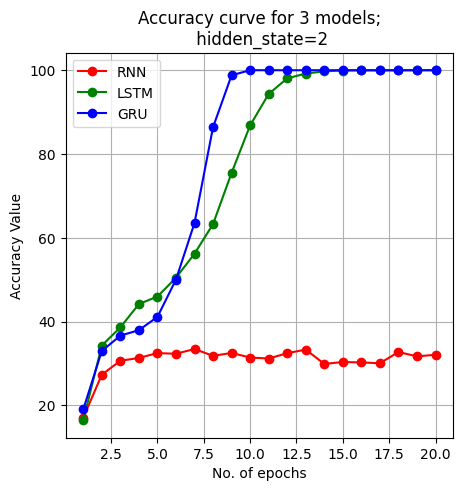

In [16]:
plt.figure(figsize=(5, 5))
x=np.arange(1,epochs+1,1)
plt.plot(x,train_acc_rnn,color='r',marker='o')
plt.plot(x,train_acc_lstm,color='g',marker='o')
plt.plot(x,train_acc_gru,color='b',marker='o')

plt.xlabel("No. of epochs")
plt.ylabel("Accuracy Value")
plt.legend(["RNN","LSTM","GRU"])
plt.title("Accuracy curve for 3 models;\n hidden_state=2")
plt.grid(True)

In [17]:
np.mean(test_acc_rnn),np.mean(test_acc_lstm),np.mean(test_acc_gru)

(30.970000000000006, 77.14, 80.21000000000001)

#### TODO : NEED TO CHECK Q2 FOR HIDDEN STATE 2 AND 5 AND REPORT ACC FOR ALL HIDDEN STATE

In [19]:


def custom_checking(model,device):
    for L in range(3,11):
        
        desired_position=np.random.randint(0,L)
        seq_gen,x,y=modelled_sequence(L,desired_position)
        print("The sequence generated is {} and desired position is {}".format(seq_gen.detach().cpu().numpy(),desired_position))
        x=x.to(device)
        y=y.to(device)


        prediction=model(x)
        
        val=np.argmax(prediction.detach().cpu().numpy())
        
        print(f"The number at the desired position as predicted by the model is {val}\n")

    
        
        

In [21]:
custom_checking(lstm_model,device)

The sequence generated is [7. 5. 3.] and desired position is 0
The number at the desired position as predicted by the model is 7

The sequence generated is [4. 5. 2. 4.] and desired position is 2
The number at the desired position as predicted by the model is 6

The sequence generated is [1. 2. 2. 5. 4.] and desired position is 0
The number at the desired position as predicted by the model is 6

The sequence generated is [8. 3. 1. 0. 5. 7.] and desired position is 4
The number at the desired position as predicted by the model is 7

The sequence generated is [4. 7. 5. 7. 5. 6. 8.] and desired position is 5
The number at the desired position as predicted by the model is 7

The sequence generated is [0. 4. 3. 8. 5. 2. 3. 6.] and desired position is 2
The number at the desired position as predicted by the model is 6

The sequence generated is [1. 7. 2. 4. 3. 3. 0. 0. 5.] and desired position is 8
The number at the desired position as predicted by the model is 7

The sequence generated is [